# Install the YOLOV5 folder

In [1]:
import os
import shutil
from codecarbon import OfflineEmissionsTracker

if not os.path.exists("yolov5"):
    !git clone https://github.com/ultralytics/yolov5
else:
    print("The yolov5 repository has been cloned.")
pathInicial=os.getcwd() 
os.chdir("yolov5")
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

The yolov5 repository has been cloned.
Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=7982MB, multi_processor_count=36)


# We load the roboflow data of the wheelchair.

In [2]:
if not os.path.exists("wheelchair-detection-1"):
    from roboflow import Roboflow
    rf = Roboflow(api_key="GTFcmyUsIPX2cUOUUP8y")
    project = rf.workspace("2458761304-qq-com").project("wheelchair-detection")
    dataset = project.version(1).download("yolov5")
else:
    print("Good,¡The data is already load!")

Good,¡The data is already load!


# We apply data reduction

In [4]:
os.chdir(pathInicial)
method = "FES"
perc=0.25
!python ReductionDatasetRoboflow.py --name {method} --perc {perc}

2024-02-20 08:08:12.622612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 08:08:12.622650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 08:08:12.623725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Selected Method:  FES
Selected reduction rate:  0.25
There are 463 images in the path yolov5/wheelchair-detection-1/train
YOLOv5 🚀 2024-1-18 Python-3.9.18 torch-1.12.1+cu113 CUDA:0 (Quadro RTX 4000, 7982MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 
100%|████████████████████████████████████████| 463/463 

# We updated the data yaml, in order to correctly run the training and evaluation of the model with the reduced data.

In [19]:
os.chdir("yolov5")
print("Original Yaml")
%cat wheelchair-detection-1/data.yaml

import yaml
with open("wheelchair-detection-1" + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

Original Yaml
names:
- people
- peopleWithWheelchair
nc: 2
roboflow:
  license: CC BY 4.0
  project: wheelchair-detection
  url: https://universe.roboflow.com/2458761304-qq-com/wheelchair-detection/dataset/1
  version: 1
  workspace: 2458761304-qq-com
test: wheelchair-detection-1/test/images
train: wheelchair-detection-1/train/images
val: wheelchair-detection-1/test/images


In [20]:
%%writetemplate wheelchair-detection-1/data.yaml
names:
- people
- peopleWithWheelchair
nc: 2
roboflow:
  license: CC BY 4.0
  project: wheelchair-detection
  url: https://universe.roboflow.com/2458761304-qq-com/wheelchair-detection/dataset/1
  version: 1
  workspace: 2458761304-qq-com
test: wheelchair-detection-1/test/images
train: wheelchair-detection-1/train/images
val: wheelchair-detection-1/test/images

In [21]:
print("Modified Yaml")
%cat wheelchair-detection-1/data.yaml

Modified Yaml
names:
- people
- peopleWithWheelchair
nc: 2
roboflow:
  license: CC BY 4.0
  project: wheelchair-detection
  url: https://universe.roboflow.com/2458761304-qq-com/wheelchair-detection/dataset/1
  version: 1
  workspace: 2458761304-qq-com
test: wheelchair-detection-1/test/images
train: wheelchair-detection-1/train/images
val: wheelchair-detection-1/test/images


#  We train YOLOV5 on our reduced dataset

In [22]:
os.chdir(pathInicial + '/yolov5')
for i in range(5): #different seed
    tracker = OfflineEmissionsTracker(country_iso_code="ESP",log_level="ERROR")
    tracker.start()
    seed=i
    comando = f"python train.py --img 640 --batch 16 --epochs 100 --data wheelchair-detection-1/data.yaml --weights yolov5m.pt --freeze 10 --name yolov5_results_{method}_{perc}_{seed} --cache --seed {seed}"
    !{comando}
    print("Estimated emissions: ", tracker.stop() * 1000, " CO2 grams")
    os.remove("emissions.csv")

[codecarbon INFO @ 11:59:16] offline tracker init


train: weights=yolov5m.pt, cfg=, data=wheelchair-detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5_results_FES_0.25_0, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.9.18 torch-1.12.1+cu113 CUDA:0 (Quadro RTX 4000, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmu

# Evaluating the performance of our customized YOLOV5

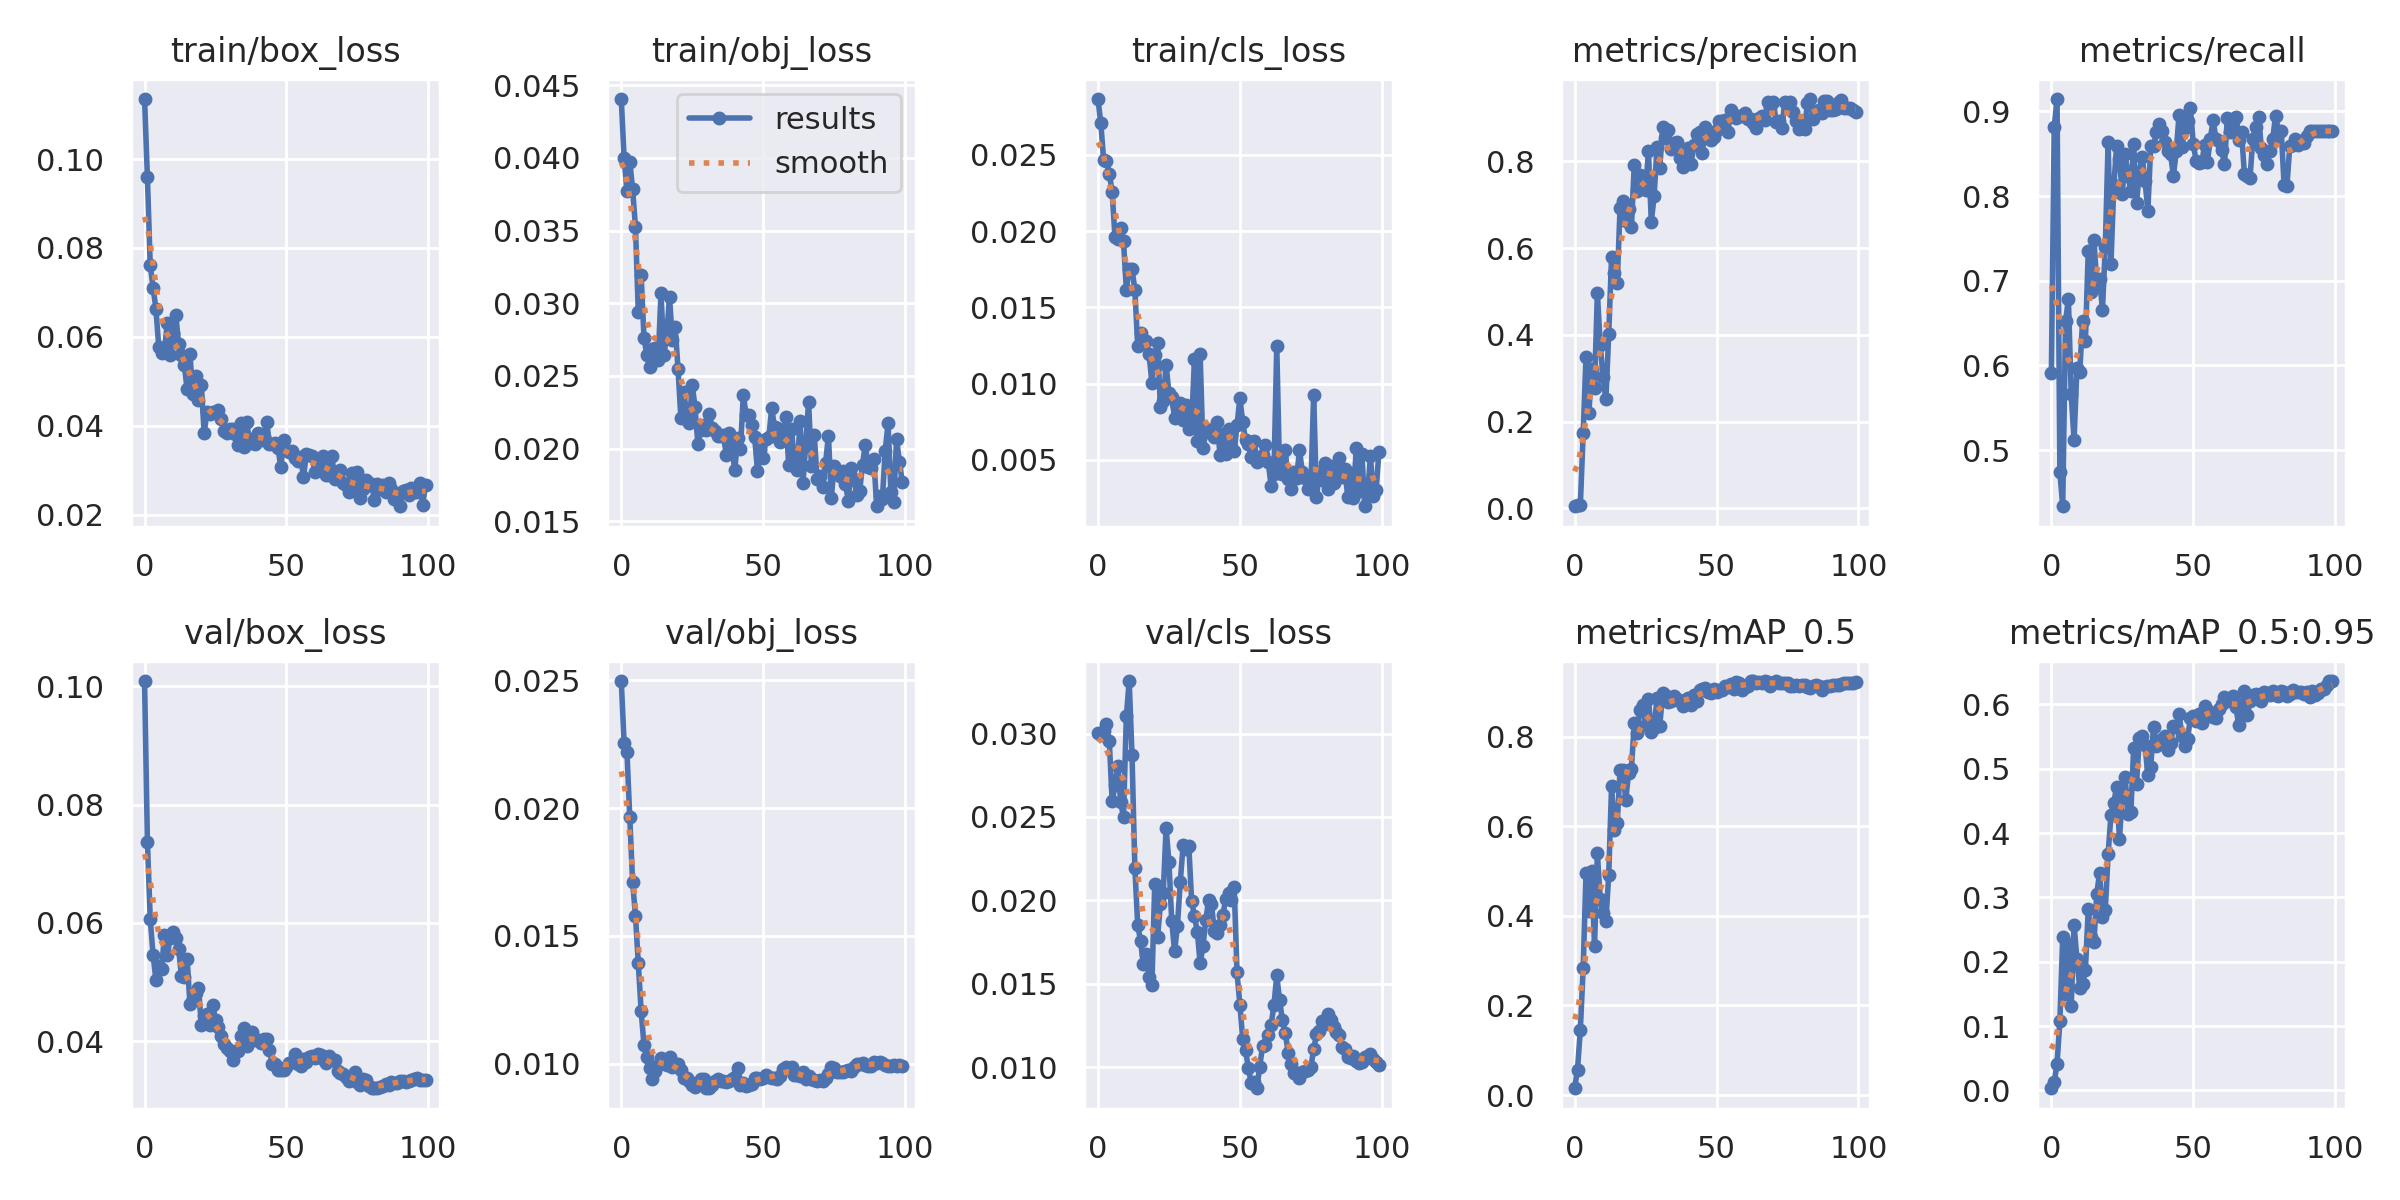

In [23]:
from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename=f'runs/train/yolov5_results_{method}_{perc}_{seed}/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


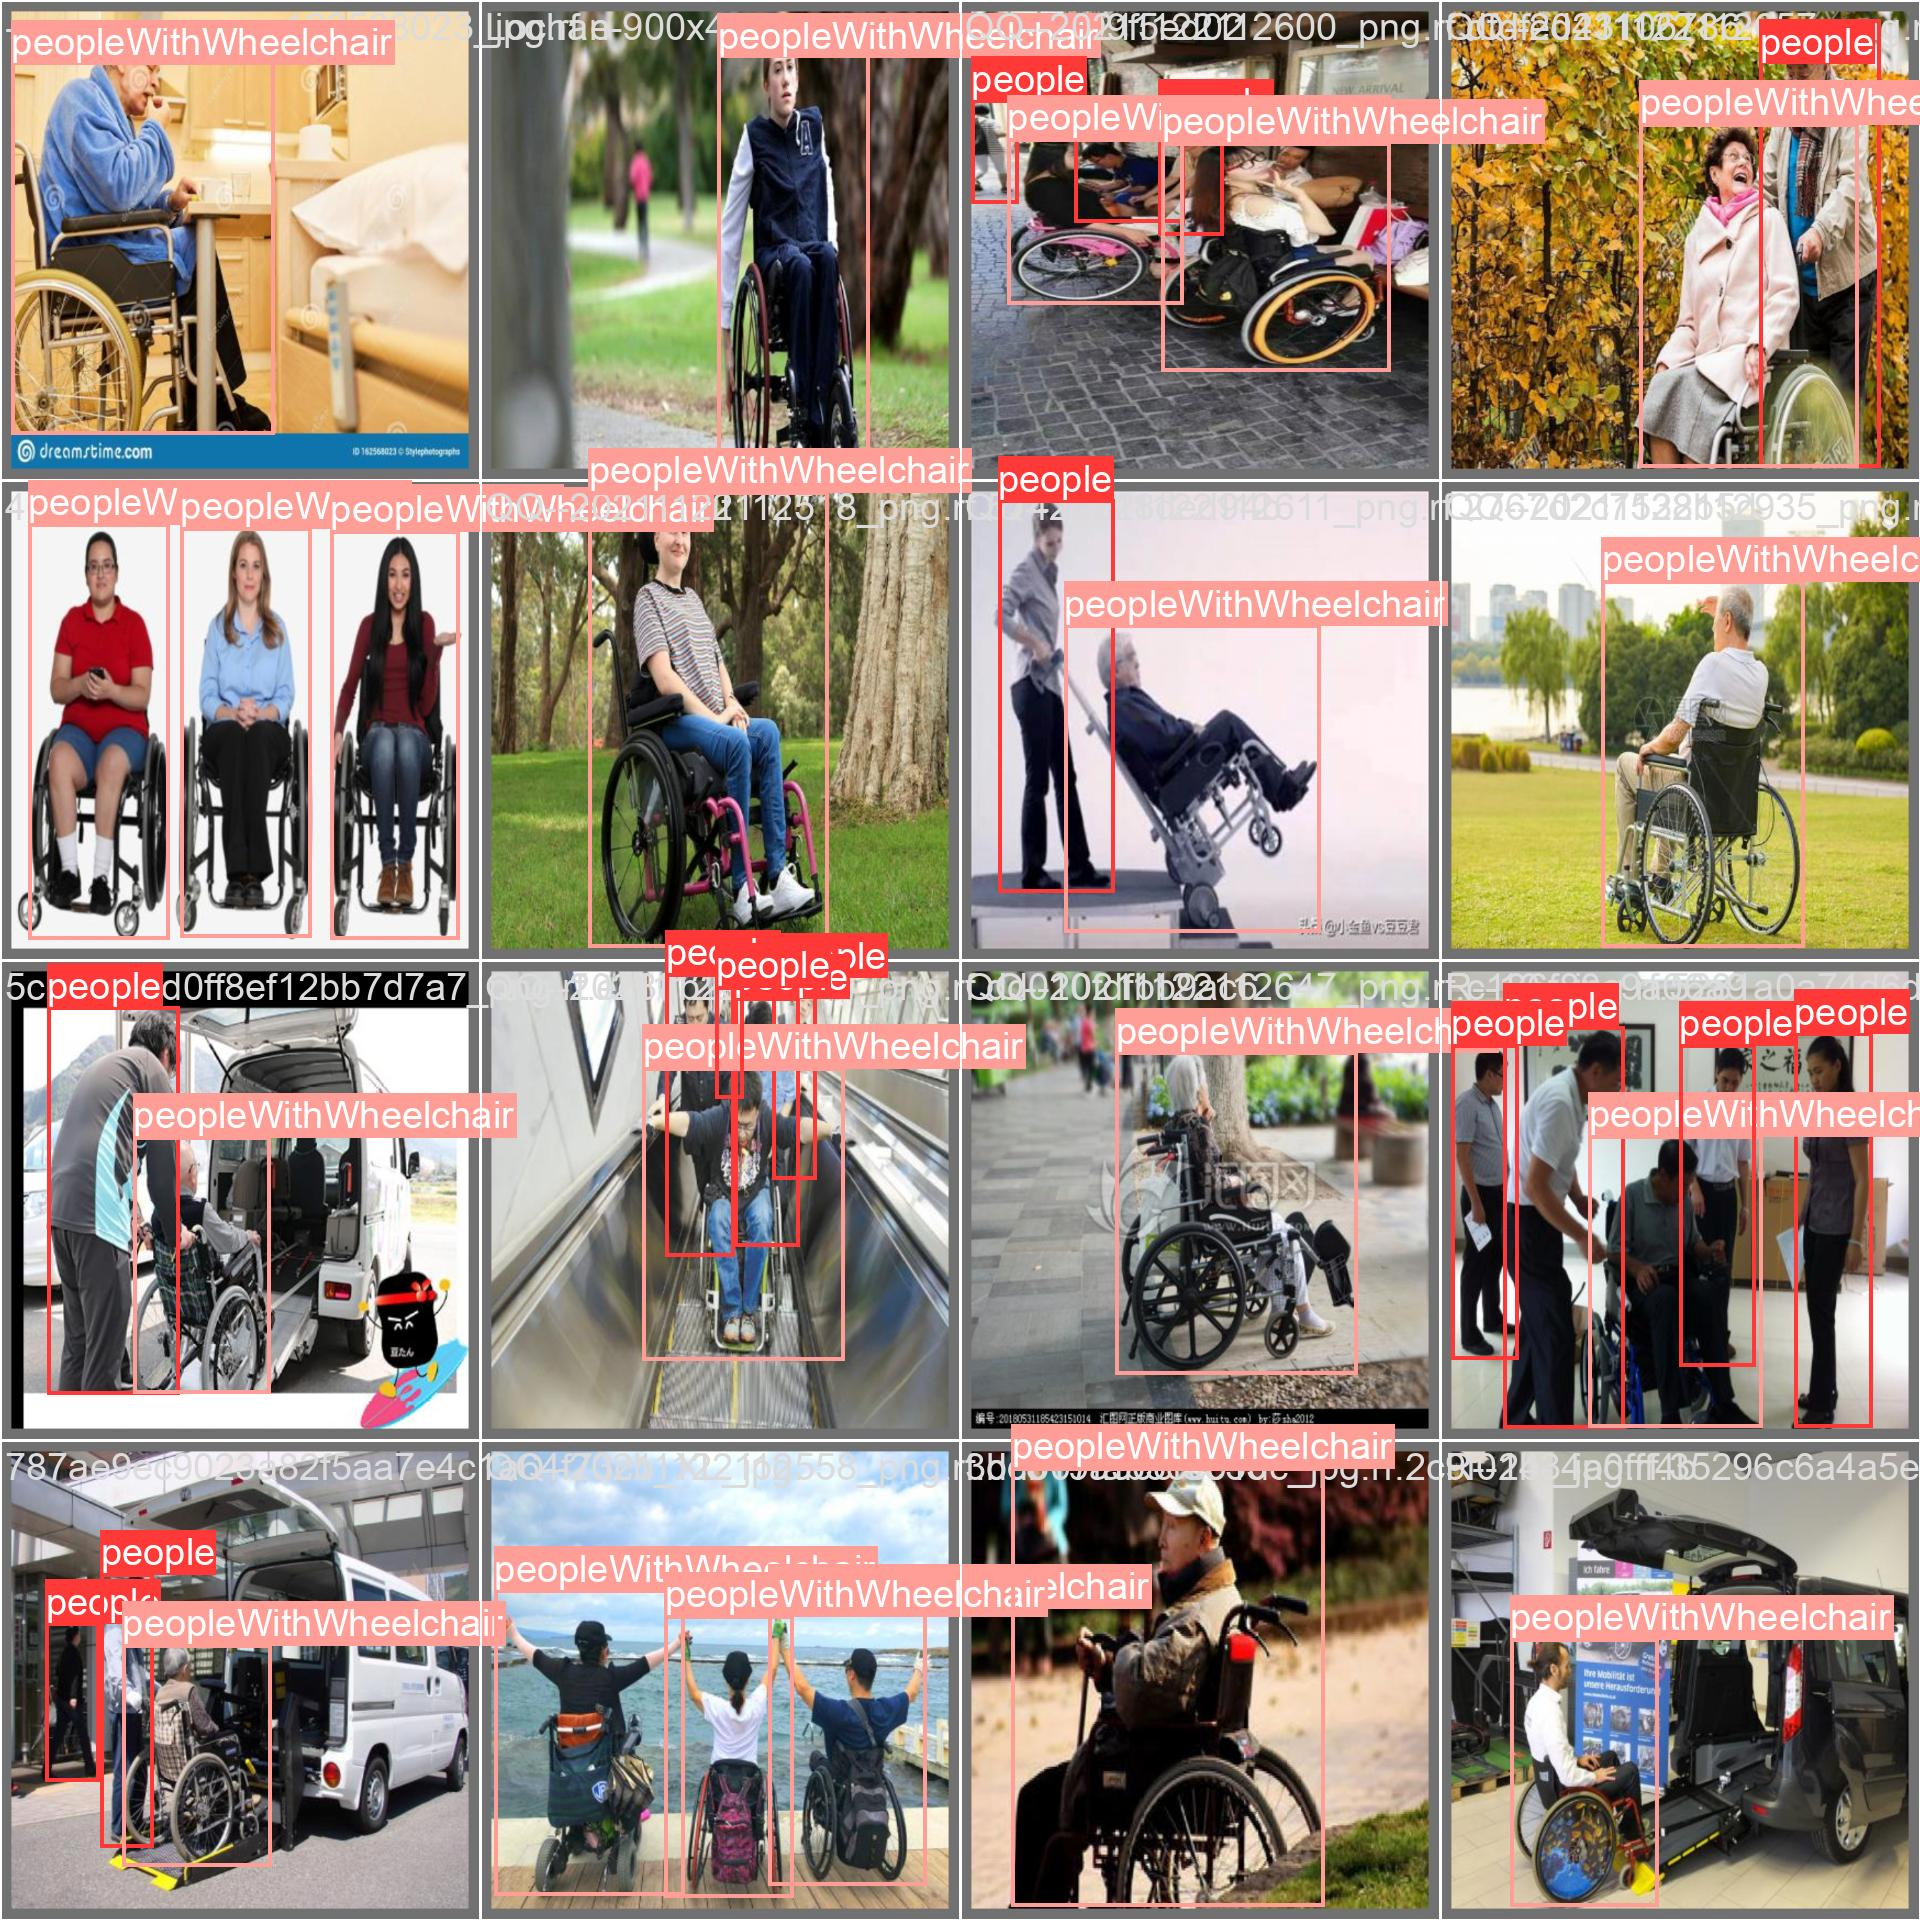

In [24]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename=f'runs/train/yolov5_results_{method}_{perc}_{seed}/val_batch0_labels.jpg', width=900)

# We make inference with our trained weights (with the best model).

In [25]:
comando = f'python detect.py --weights runs/train/yolov5_results_{method}_{perc}_{seed}/weights/best.pt --img 416 --conf 0.4 --source wheelchair-detection-1/test/images'
!{comando}

detect: weights=['runs/train/yolov5_results_FES_0.25_4/weights/best.pt'], source=wheelchair-detection-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.9.18 torch-1.12.1+cu113 CUDA:0 (Quadro RTX 4000, 7982MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/51 /home/vtoscano/Investigacion/repoNuevo/yolov5/wheelchair-detection-1/test/images/----------------------162568023_jpg.rf.e92b585ffe0fee57d9c7848ed2e99fbe.jpg: 416x416 1 peopleWithWheelchair, 14.0ms
image 2/51 /home/vtoscano/Investigacion/repoNuevo/yolov5/wheelchair-detection-

# We show the inference for all the test images

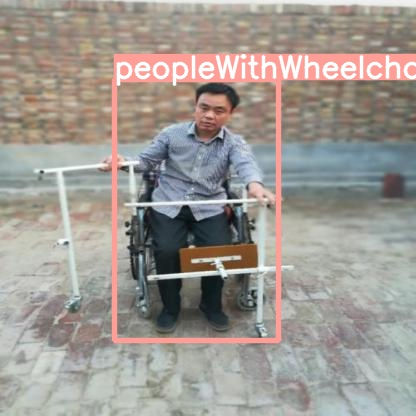

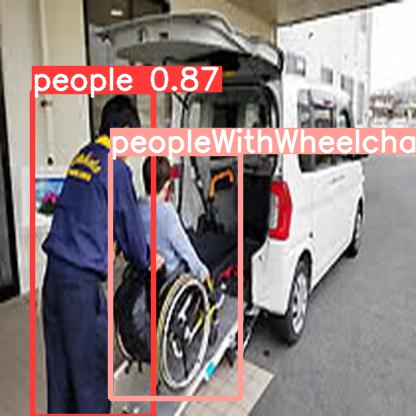

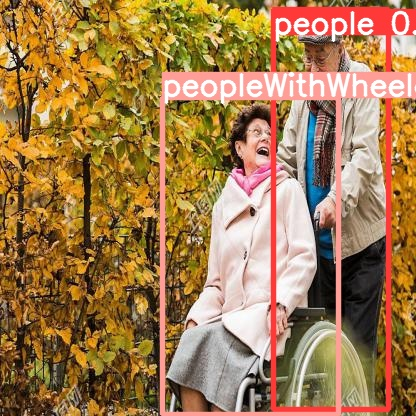

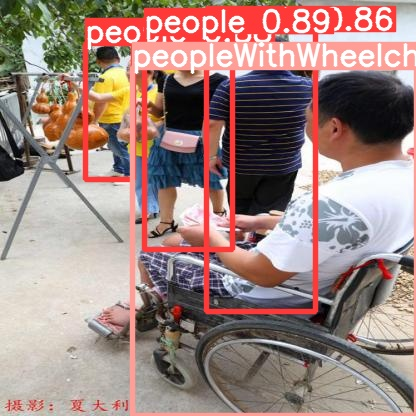

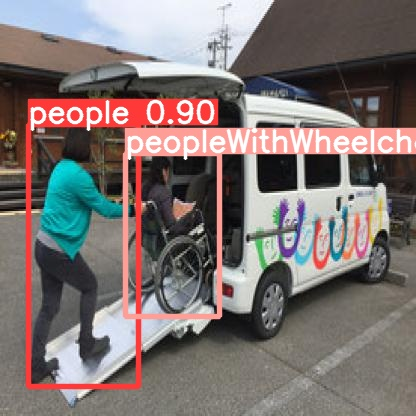

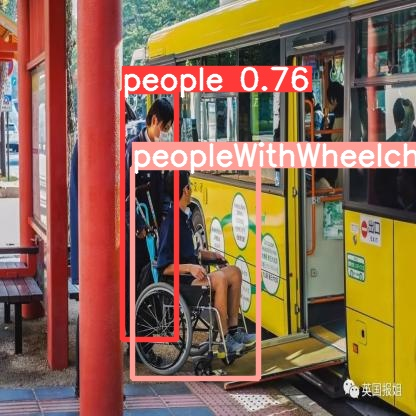

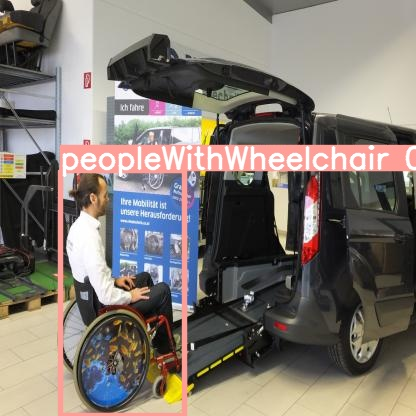

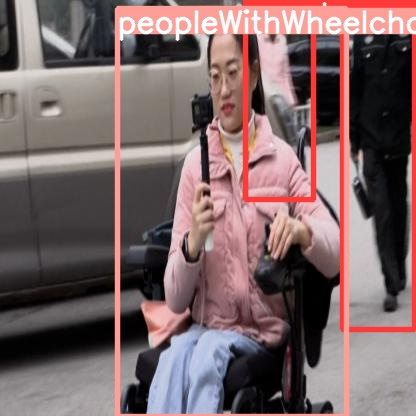

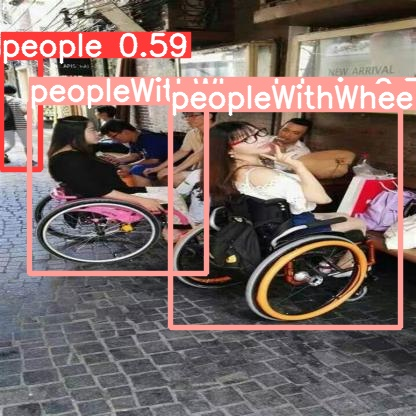

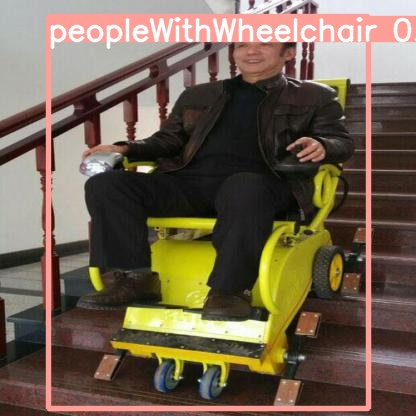

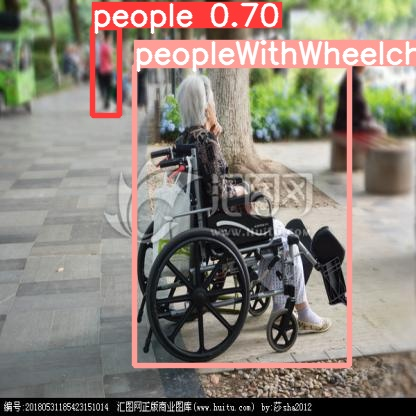

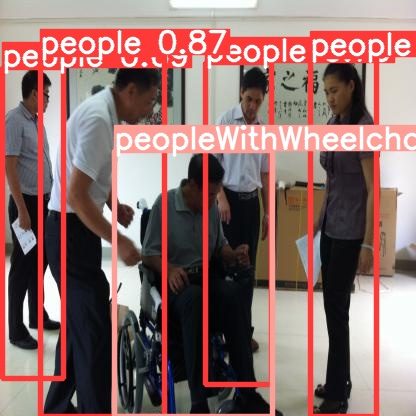

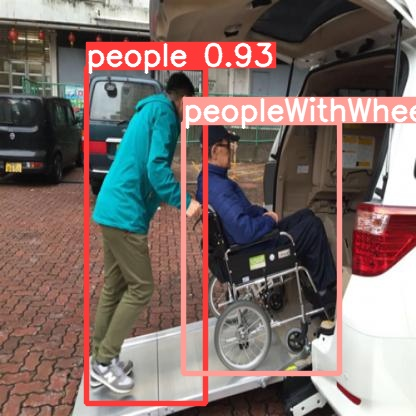

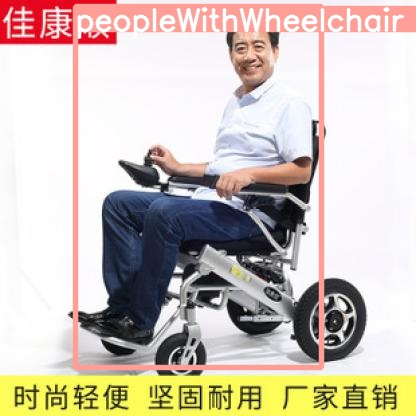

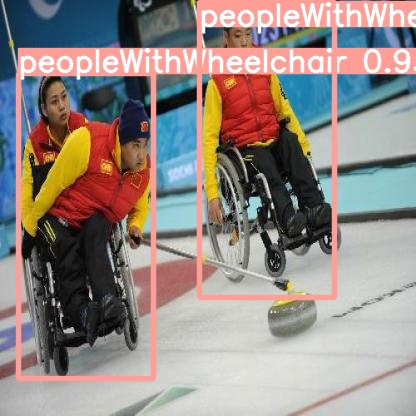

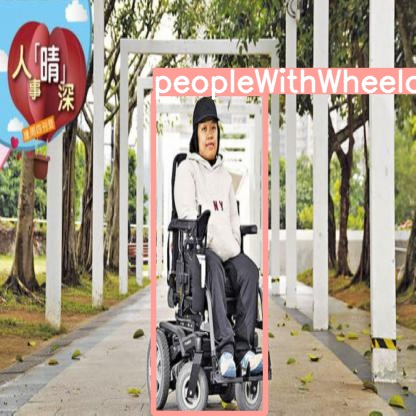

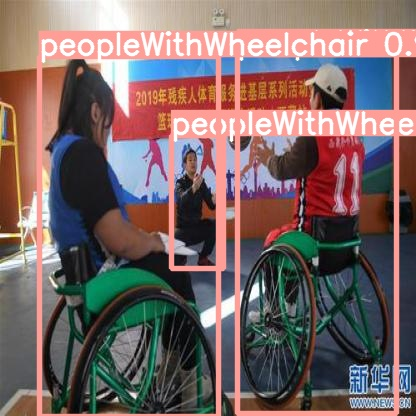

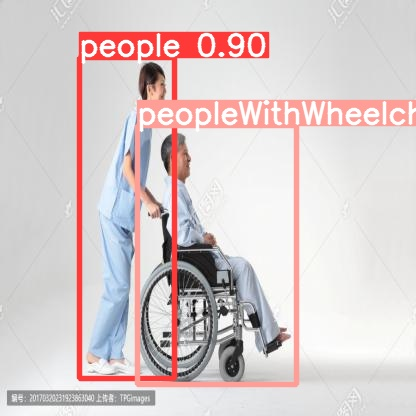

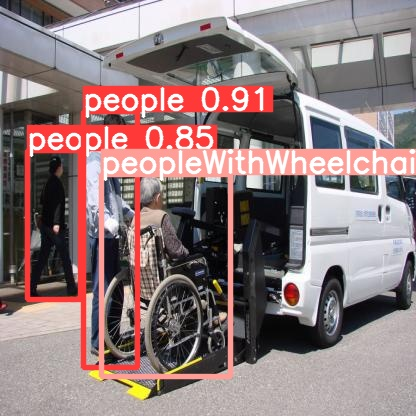

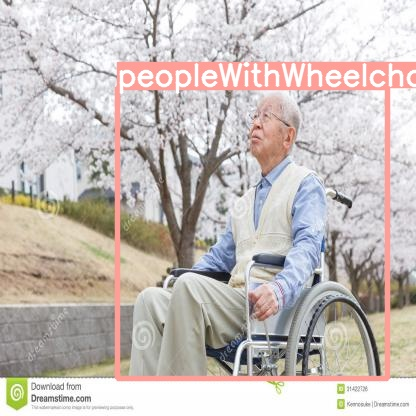

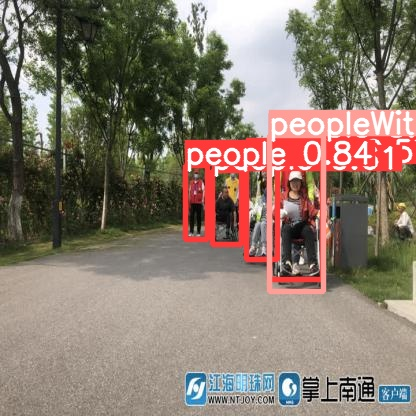

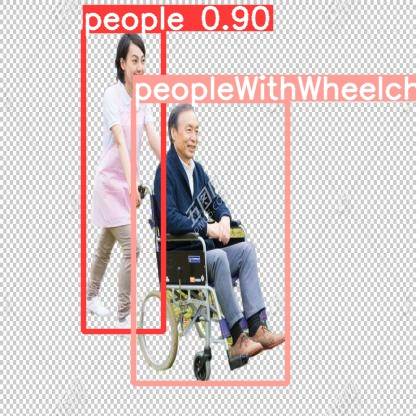

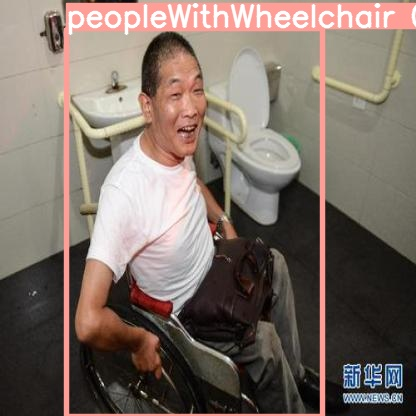

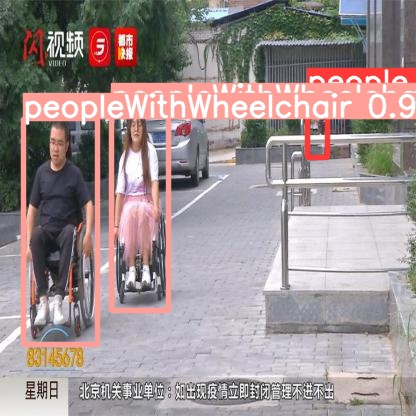

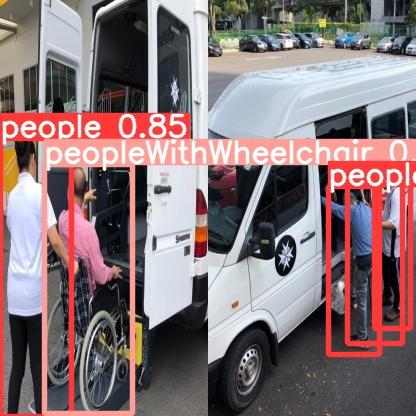

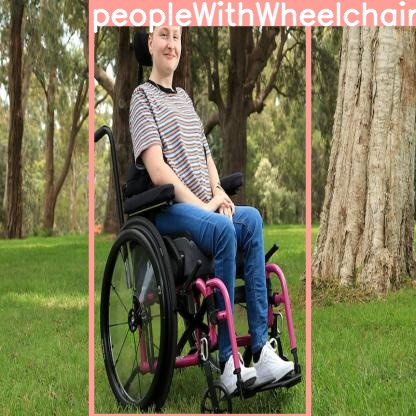

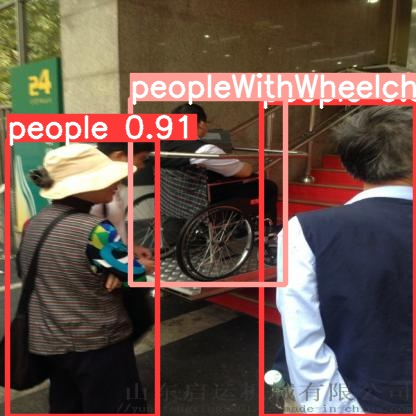

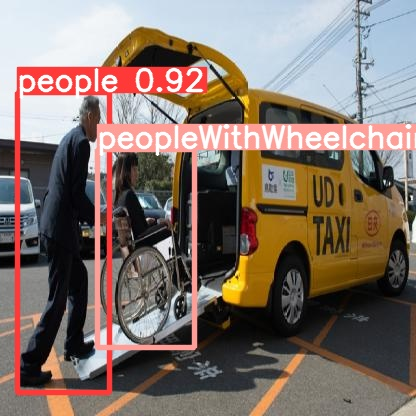

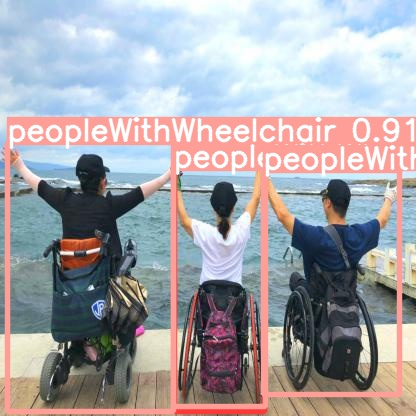

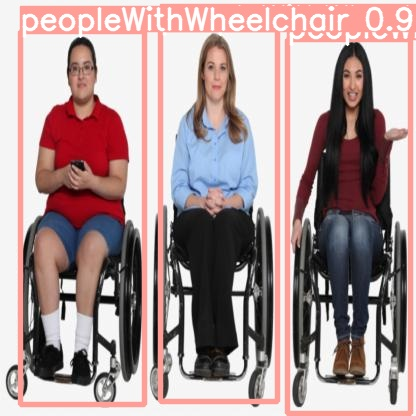

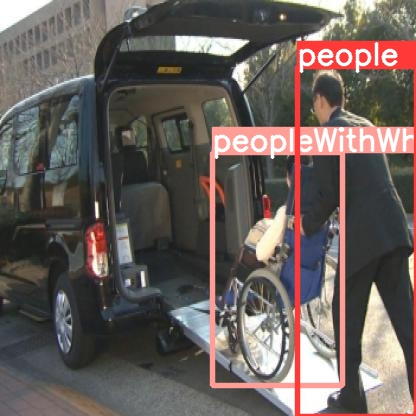

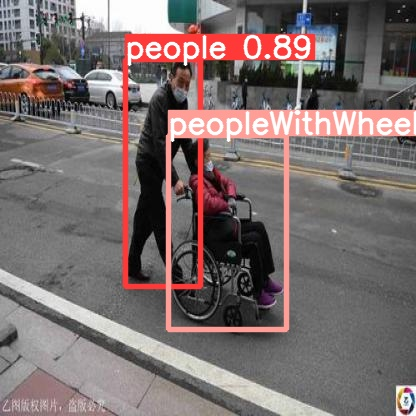

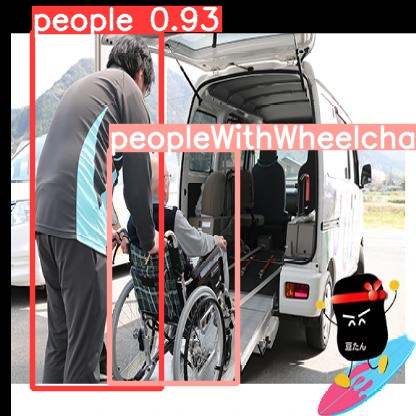

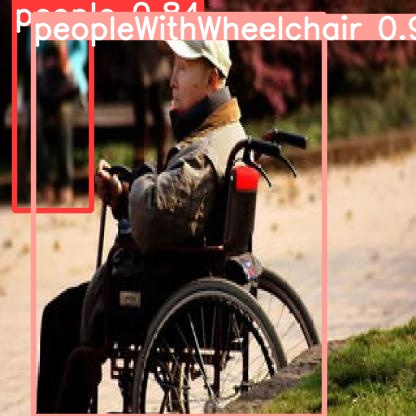

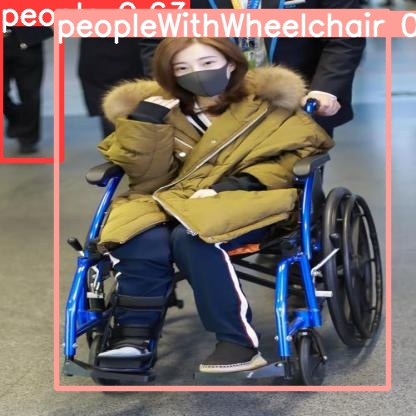

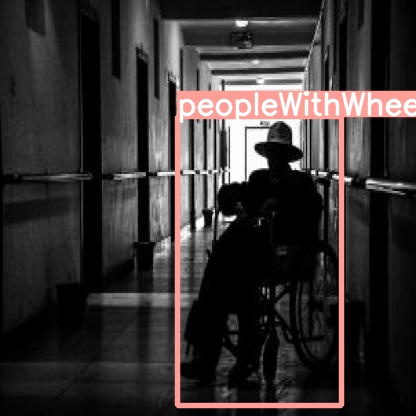

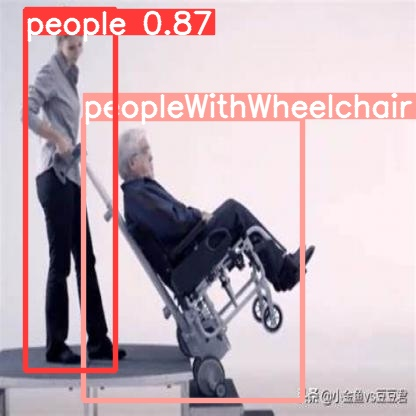

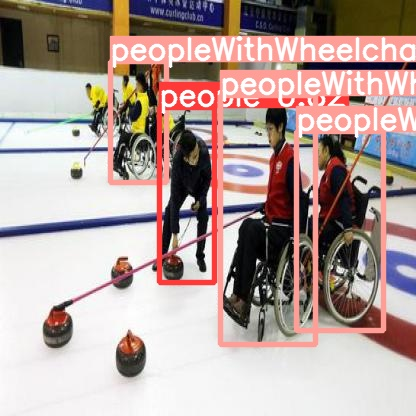

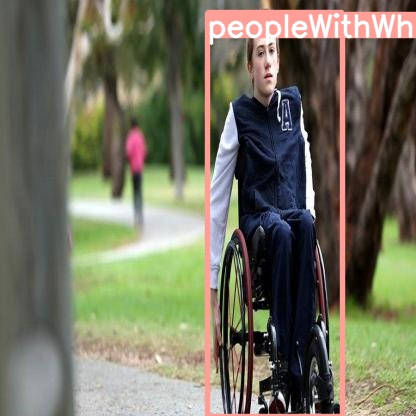

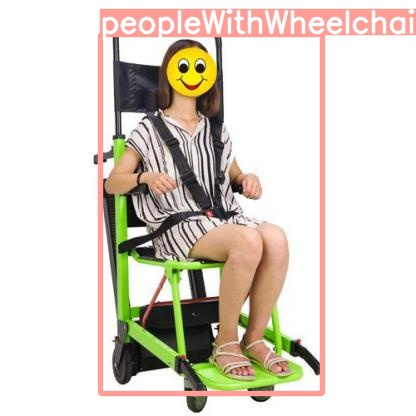

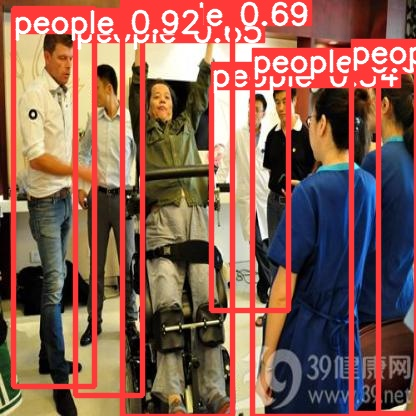

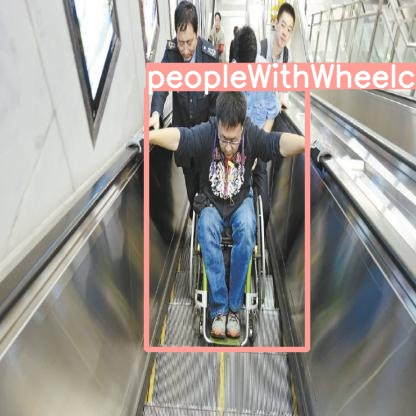

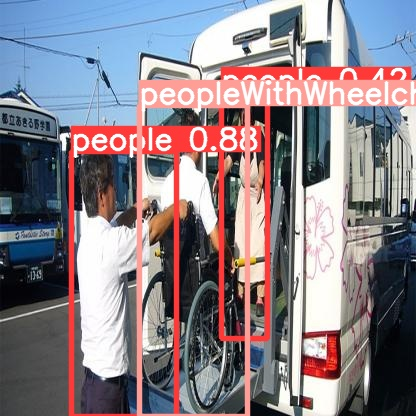

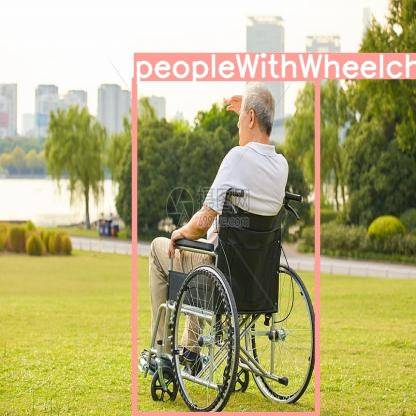

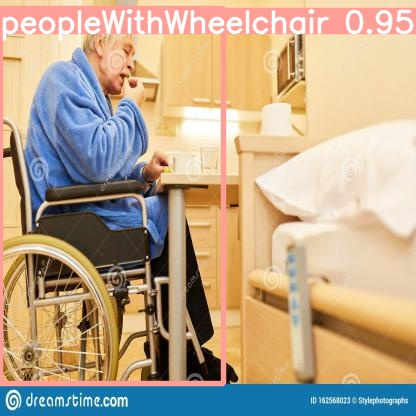

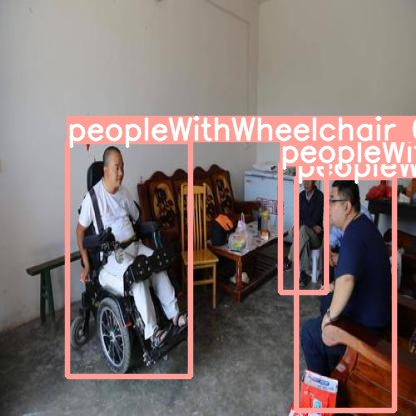

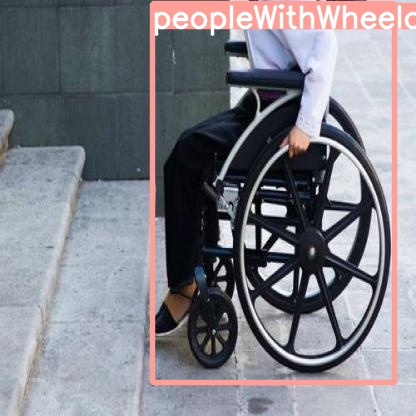

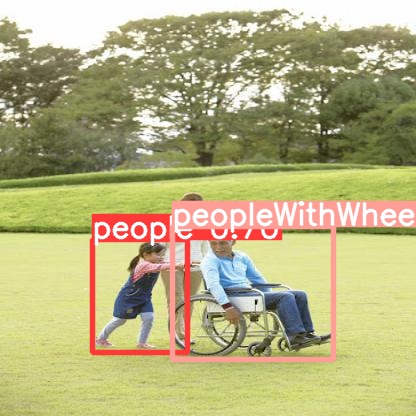

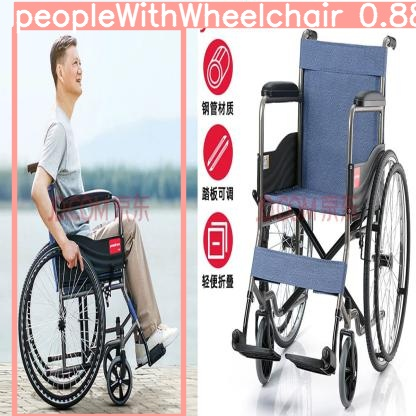

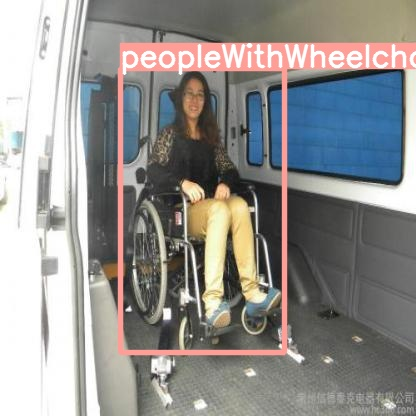

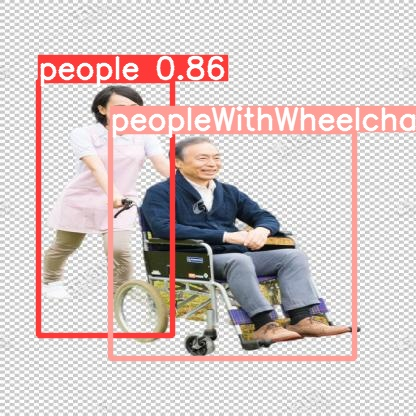

In [27]:
import glob
for imageName in glob.glob('runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")